# Mapping and merging

In this notebook, we are going to work a bit on making a shapefile and blending it with disease data. We used old maps to create a shapefile of the old wards of New York City, which can be found in the project's Data file. 

### ⭐ Note! ⭐

This is an old notebook which probably needs to be massaged a bit to work more correctly with newer data. Anyways...

Anyways, let's start it up and see how it goes:

In [22]:
import geopandas as gpd
import mplleaflet
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from geopandas import GeoDataFrame
from IPython.display import HTML
from scipy.stats import pearsonr

%matplotlib inline

In [3]:
workdir = os.getcwd()
try:
    os.chdir(workdir + '//Data')
except:
    print("already there...")

In [4]:
Wards = gpd.read_file('NYCWards1900.shp')

Just a check to make sure everything is working...

<Axes: >

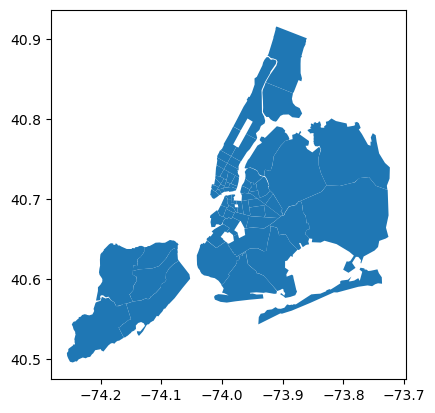

In [5]:
Wards.plot()

In [6]:
Wards.head()

,cartodb_id,descriptio,name,geometry
0,60,"Tenth Ward, Manhattan",MN Ward 10,"POLYGON ((-73.99348 40.72163, -73.98670 40.719..."
1,3,"First Ward, Brooklyn",BK Ward 1,"POLYGON ((-73.99060 40.68912, -74.00185 40.692..."
2,6,"Fifth Ward, Brooklyn",BK Ward 5,"POLYGON ((-73.98517 40.69491, -73.98436 40.705..."
3,22,"Twenty-First Ward, Brooklyn",BK Ward 21,"POLYGON ((-73.95704 40.69909, -73.94176 40.700..."
4,9,"Tenth Ward, Brooklyn",BK Ward 10,"POLYGON ((-73.99150 40.67501, -73.99648 40.677..."


In [7]:
Wards.name

0     MN Ward 10
1      BK Ward 1
2      BK Ward 5
3     BK Ward 21
4     BK Ward 10
         ...    
61     RI Ward 4
62    BX Ward 24
63     MN Ward 6
64    MN Ward 14
65    MN Ward 12
Name: name, Length: 66, dtype: object

We see that the best way of identifying or merging the data is seemingly by using the "name" code inthe Wards data. So, we will have to munge the data to get that to work correctly. Here goes - after first reading in the data:

In [8]:
Data = pd.read_stata('190313mod.dta')

In [9]:
set(Data['borough'])

{'BR', 'BX', 'MA', 'QU', 'RI'}

In [10]:
splitnames =  [name.split() for name in Wards['name']]

In [11]:
Wards['borough'] = [split[0] for split in splitnames]
Wards['number']  = [split[2] for split in splitnames]

Now that the boroughs have been split out of the tag that we gave them, we can change the tags so that they correspond with those in our data.

In [12]:
Wards['borough'].loc[Wards['borough'] == 'MN'] = 'MA'
Wards['borough'].loc[Wards['borough'] == 'QN'] = 'QU'
Wards['borough'].loc[Wards['borough'] == 'BK'] = 'BR'

C:\Users\mjbaker\AppData\Local\Temp\ipykernel_6648\3630161185.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Wards['borough'].loc[Wards['borough'] == 'MN'] = 'MA'
C:\Users\mjbaker\AppData\Local\Temp\ipykernel_6648\3630161185.py:1: Setti

In [15]:
Wards.head()

,cartodb_id,descriptio,name,geometry,borough,number
0,60,"Tenth Ward, Manhattan",MN Ward 10,"POLYGON ((-73.99348 40.72163, -73.98670 40.719...",MA,10
1,3,"First Ward, Brooklyn",BK Ward 1,"POLYGON ((-73.99060 40.68912, -74.00185 40.692...",BR,1
2,6,"Fifth Ward, Brooklyn",BK Ward 5,"POLYGON ((-73.98517 40.69491, -73.98436 40.705...",BR,5
3,22,"Twenty-First Ward, Brooklyn",BK Ward 21,"POLYGON ((-73.95704 40.69909, -73.94176 40.700...",BR,21
4,9,"Tenth Ward, Brooklyn",BK Ward 10,"POLYGON ((-73.99150 40.67501, -73.99648 40.677...",BR,10


This code basically just deals with the problem posed by the twelfth ward being composed of four subwards in the data. So, we combine them...

In [16]:
Slice = Data[Data['wards'].str.contains("Twelfth")]
Slice = Slice[Slice['year'] > 1911]
Slice = Slice[Slice['borough'] == 'MA']

There must be a better way to do this, but we will make a new row manually...

In [17]:
Slice['wards'].loc[Slice['wards'] == 'TwelfthN'] = 'Twelfth'
Slice['populationbycensusof1900'].loc[Slice['wards'] == 'Twelfth'] = (205130+332692+103532+165294)
Slice['numberofpersonstotheacre'].loc[Slice['wards'] == 'Twelfth'] = 86.599998

C:\Users\mjbaker\AppData\Local\Temp\ipykernel_6648\3233343825.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Slice['wards'].loc[Slice['wards'] == 'TwelfthN'] = 'Twelfth'
C:\Users\mjbaker\AppData\Local\Temp\ipykernel_6648\3233343825.py:2

In [18]:
Slice['typhoidfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = (13+23+18+6)
Slice['typhoidfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = (8+17+17+12)
Slice['malarialfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 0
Slice['malarialfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 2
Slice['measles'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 54+23+9+6
Slice['measles'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 55+15+4+4
Slice['scarletfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 30+18+6+10
Slice['scarletfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 11+32+5+4
Slice['whoopingcough'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 22+15+6+4
Slice['whoopingcough'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 36+23+6+6
Slice['diphteria'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 61+33+21+16
Slice['diphteria'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 92+53+29+23
Slice['pulmonarytuberculosisphithisis'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 316+387+161+150
Slice['pulmonarytuberculosisphithisis'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 334+502+234+153
Slice['cerebrospinalmeningitis'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 16+4+4+5
Slice['cerebrospinalmeningitis'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 9+12+3+1
Slice['pneumonia'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 274+281+153+116
Slice['pneumonia'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 222+315+166+113
Slice['bronchopneumonia'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 333+191+79+54
Slice['bronchopneumonia'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 359+209+87+45
Slice['diarrhealdiseases'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 293+138+69+50
Slice['diarrhealdiseases'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 258+147+62+44
Slice['allcauses'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 3421+3728+2307+1637
Slice['allcauses'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 3100+4225+2468+1571
Slice['deathsofchildrenunder5years'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = 1454+810+347+285
Slice['deathsofchildrenunder5years'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1913)] = 1356+940+367+275

C:\Users\mjbaker\AppData\Local\Temp\ipykernel_6648\4180417187.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Slice['typhoidfever'].loc[(Slice['wards'] == 'Twelfth') & (Slice['year'] == 1912)] = (13+23+18+6)
C:\Users\mjbaker\AppData\Loca

In [19]:
Slice = Slice.loc[Slice['wards'] == 'Twelfth']

In [20]:
Data = Data.loc[(Data['wards'] != 'TwelfthN')]
Data = Data.loc[(Data['wards'] != 'TwelfthC')]
Data = Data.loc[(Data['wards'] != 'TwelfthE')]
Data = Data.loc[(Data['wards'] != 'TwelfthW')]
Data = Data.loc[(Data['wards'] != 'Total')]

In [21]:
Data = Data.append(Slice)

AttributeError: 'DataFrame' object has no attribute 'append'

# At this point...

We now have a clean bunch of data, and we only have to clean up the numbering of the wards. 

In [76]:
translator = {'Eighteenth':18, 'Eighth':8, 'Eleventh':11, 'Fifteenth':15, 'Fifth':5, 'First':1, 'Fourteenth':14,
 'Fourth':4, 'Nineteenth':19, 'Ninth':9, 'Second':2, 'Seventeenth':17, 'Seventh':7, 'Sixteenth':16, 'Sixth':6, 'Tenth':10,
 'Third':3, 'Thirteenth':13, 'Thirtieth':30, 'Thirty-first':31, 'Thirty-second':32, 'Twelfth':12, 'Twentieth':20,
              'Twenty-Third':23,
 'Twenty-eigth':28, 'Twenty-fifth':25, 'Twenty-first':21, 'Twenty-fourth':24, 'Twenty-ninth':29, 'Twenty-second':22,
 'Twenty-seventh':27, 'Twenty-sixth':26, 'Twenty-third':23}

In [52]:
Data['wardno']= Data['wards'].map(translator)

In [77]:
Wards.rename(columns={'number': 'wardno'}, inplace=True)
Wards['wardno'] = [int(wn) for wn in Wards['wardno']]

In [79]:
MergedData = Data.merge(Wards, how='outer', left_on=['borough', 'wardno'], right_on=['borough', 'wardno'])

In [80]:
MergedData = GeoDataFrame(MergedData)

Let's comb through the data and replace population numbers where we have them. This gives:

In [229]:
foo = []
for p in MergedData['populationbycensusof1900']:
    try:
        foo.append(float(p.replace(',', '')))
    except:
        foo.append(np.nan)
        
MergedData['pop'] = foo

foo = []
i=0
for p in MergedData['diarrhealdiseases']:
    try:
        foo.append(float(p))
    except:
        foo.append(np.nan)
        
MergedData['diarrhea'] = foo

foo = []
i=0
for p in MergedData['allcauses']:
    try:
        foo.append(float(p))
    except:
        foo.append(np.nan)
        
MergedData['allcauses'] = foo

Let's now look at how many deaths per capita we have from a few things:

In [230]:
MergedData['typhpercap'] = MergedData['typhoidfever'] / MergedData['pop'] * 1000
MergedData['malpercap']  = MergedData['malarialfever'] / MergedData['pop'] * 1000
MergedData['mengpercap'] = MergedData['cerebrospinalmeningitis'] / MergedData['pop'] * 1000
MergedData['diarpercap'] = MergedData['diarrhea'] / MergedData['pop'] * 1000
MergedData['measpercap'] = MergedData['measles'] / MergedData['pop'] * 1000
MergedData['pnupercap']  = MergedData['pneumonia'] / MergedData['pop'] * 1000
MergedData['allpercap']  = MergedData['allcauses'] / MergedData['pop'] * 1000

In [231]:
tomap = MergedData.loc[MergedData['year'] == 1908]

C:\Users\mjbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


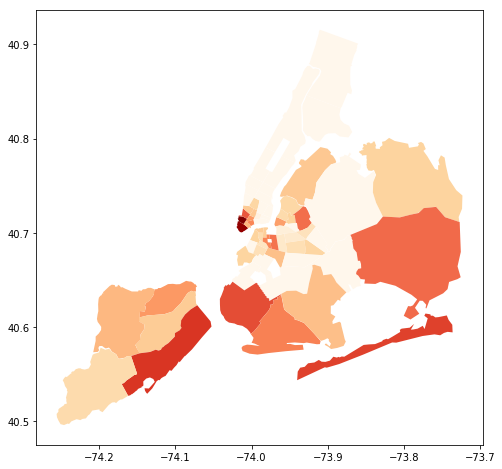

In [233]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax    = tomap.plot(ax=ax, column='allpercap', cmap='OrRd')
plt.show()

The above seems to basically get the basic idea about right. Let's now look at a simple example of how diseases correlate with population density...

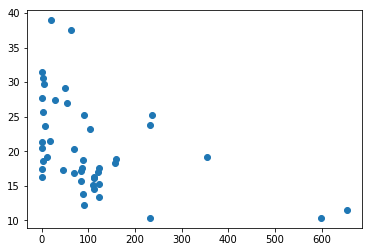

In [237]:
plt.scatter( tomap['numberofpersonstotheacre'], tomap['allpercap'])

In [258]:
afflictions = ['malpercap','numberofpersonstotheacre', 'typhpercap', 'mengpercap', 
       'diarpercap', 'measles', 'pneumonia', 'allpercap']

print(tomap[afflictions].corr())
print(tomap[afflictions].mean())

                          malpercap  numberofpersonstotheacre  typhpercap  \
malpercap                  1.000000                 -0.158958    0.216683   
numberofpersonstotheacre  -0.158958                  1.000000   -0.271128   
typhpercap                 0.216683                 -0.271128    1.000000   
mengpercap                -0.064969                 -0.031497    0.126394   
diarpercap                 0.391468                 -0.322551    0.305576   
measles                   -0.095306                 -0.015210    0.071510   
pneumonia                 -0.053826                  0.078820    0.066795   
allpercap                  0.148330                 -0.444113    0.604452   

                          mengpercap  diarpercap   measles  pneumonia  \
malpercap                  -0.064969    0.391468 -0.095306  -0.053826   
numberofpersonstotheacre   -0.031497   -0.322551 -0.015210   0.078820   
typhpercap                  0.126394    0.305576  0.071510   0.066795   
mengpercap    

In [240]:
tomap['diptheria']

KeyError: 'diptheria'

In [242]:
tomap.columns

Index(['year', 'borough', 'wards', 'areainacres', 'populationbycensusof1900',
       'numberofpersonstotheacre', 'typhoidfever', 'malarialfever', 'smallpox',
       'measles', 'scarletfever', 'whoopingcough', 'diphteria',
       'pulmonarytuberculosisphithisis', 'cerebrospinalmeningitis',
       'pneumonia', 'bronchopneumonia', 'diarrhealdiseases', 'allcauses',
       'deathsininstitution', 'deathsofchildrenunder5years', 'wardno',
       'cartodb_id', 'descriptio', 'name', 'geometry', 'pop', 'typhpercap',
       'malpercap', 'mengpercap', 'diarhea', 'diarrhea', 'diarpercap',
       'measpercap', 'pnupercap', 'allpercap'],
      dtype='object')

In [256]:
tomap['diarrhealdiseases']

5       39
19       4
33       1
47      43
61      13
75      34
89     112
103     56
117    111
131     77
145    143
159    883
173     69
187     92
201     31
215     73
229    243
243    129
257    653
271    104
285     97
299    323
313    258
327    131
341     78
355     28
369     24
383     19
397     62
411     67
      ... 
509     50
523    110
537     81
551     80
565    157
579     80
593     42
607     52
621     74
635     88
649     40
663     59
677     44
691    192
705     88
719     92
733     91
747    106
761     73
775     19
789    103
803    131
817     48
831     75
845     35
859     29
873     22
887     35
901     76
915     12
Name: diarrhealdiseases, Length: 66, dtype: object